In [33]:
import pandas as pd
import os
from rouge_score import rouge_scorer, scoring
import matplotlib.pyplot as plt
import numpy as np

In [7]:
if not 'results_tf.csv' in os.listdir('../data/') or not 'results_ed.csv' in os.listdir('../data/'):
    print("Run ed_eval.ipynb and tf_eval.ipynb before running this file.")
    exit()
results_ed = pd.read_csv('../data/results_ed.csv')
results_tf = pd.read_csv('../data/results_tf.csv')

In [8]:
# setup ROUGE scorer and tokenizer
ROUGE_METRICS = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
scorer = rouge_scorer.RougeScorer(ROUGE_METRICS, use_stemmer=True)

In [14]:
# calculate ROUGE score(s) for each dataset
actual_headlines_ed = results_ed['actual headline'].tolist()
actual_headlines_tf = results_tf['actual headline'].tolist()
predicted_headlines_ed = results_ed['predicted headline'].tolist()
predicted_headlines_tf = results_tf['predicted headline'].tolist()

def calculate_rouge_scores(ah, ph):    
    # calculate ROUGE score(s) for each dataset
    rs = []
    for actual, predicted in zip(ah, ph):
        curr_score = scorer.score(actual, predicted)
        if len(predicted) > 0:
            rs.append(curr_score)
    return rs

rouge_scores = {'tf': [], 'ed': []}
rouge_scores['tf'] = calculate_rouge_scores(actual_headlines_tf, predicted_headlines_tf)
rouge_scores['ed'] = calculate_rouge_scores(actual_headlines_ed, predicted_headlines_ed)
print(rouge_scores)

{'tf': [{'rouge1': Score(precision=0.42857142857142855, recall=0.5, fmeasure=0.4615384615384615), 'rouge2': Score(precision=0.3333333333333333, recall=0.4, fmeasure=0.3636363636363636), 'rougeL': Score(precision=0.42857142857142855, recall=0.5, fmeasure=0.4615384615384615), 'rougeLsum': Score(precision=0.42857142857142855, recall=0.5, fmeasure=0.4615384615384615)}, {'rouge1': Score(precision=0.42857142857142855, recall=0.25, fmeasure=0.3157894736842105), 'rouge2': Score(precision=0.16666666666666666, recall=0.09090909090909091, fmeasure=0.11764705882352942), 'rougeL': Score(precision=0.42857142857142855, recall=0.25, fmeasure=0.3157894736842105), 'rougeLsum': Score(precision=0.42857142857142855, recall=0.25, fmeasure=0.3157894736842105)}, {'rouge1': Score(precision=0.2727272727272727, recall=0.2727272727272727, fmeasure=0.2727272727272727), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.18181818181818182, recall=0.18181818181818182, fmeasure=0.181

In [24]:
def get_average_scores(rs):
    avg_rouge_scores = {}
    precision = 0
    recall = 0
    fmeasure = 0
    for score in rs:
        precision += score['rouge1'].precision
        recall += score['rouge1'].recall
        fmeasure += score['rouge1'].fmeasure
    precision /= len(rs)
    recall /= len(rs)
    fmeasure /= len(rs)
    avg_rouge_scores = scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)
    return avg_rouge_scores

avg_rouge_scores_tf = get_average_scores(rouge_scores['tf'])
avg_rouge_scores_ed = get_average_scores(rouge_scores['ed'])
print(avg_rouge_scores_tf)
print(avg_rouge_scores_ed)

Score(precision=0.359910581508176, recall=0.33029747595322434, fmeasure=0.3354290499395285)
Score(precision=0.006640640497671135, recall=0.012744071117644426, fmeasure=0.008610085784358045)


In [31]:
def get_metrics(avg_scores, scores):
    avg_metrics = {'Precision': (avg_scores.precision), 'Recall': (avg_scores.recall), 'Accuracy': (avg_scores.fmeasure)}
    metrics = {
        'Precision': [x['rouge1'].precision for x in scores],
        'Recall': [x['rouge1'].recall for x in scores],
        'fmeasure': [x['rouge1'].fmeasure for x in scores]
    }
    return avg_metrics, metrics

avg_metrics_tf, metrics_tf = get_metrics(avg_rouge_scores_tf, rouge_scores['tf'])
avg_metrics_ed, metrics_ed = get_metrics(avg_rouge_scores_ed, rouge_scores['ed'])
print(avg_metrics_tf)
print(metrics_tf)

{'Precision': 0.359910581508176, 'Recall': 0.33029747595322434, 'Accuracy': 0.3354290499395285}
{'Precision': [0.42857142857142855, 0.42857142857142855, 0.2727272727272727, 0.2857142857142857, 0.2222222222222222, 0.38461538461538464, 0.25, 0.36363636363636365, 0.6153846153846154, 0.2222222222222222, 0.75, 0.2857142857142857, 0.23529411764705882, 0.16666666666666666, 0.4375, 0.18181818181818182, 0.1, 0.16666666666666666, 0.42857142857142855, 0.625, 0.5555555555555556, 0.5, 0.2222222222222222, 0.4, 0.2727272727272727, 0.35294117647058826, 0.05, 0.26666666666666666, 0.6666666666666666, 0.5, 0.3333333333333333, 0.8333333333333334, 0.16666666666666666, 0.23529411764705882, 0.0, 0.1, 0.4444444444444444, 0.5, 0.3333333333333333, 0.1, 0.42857142857142855, 0.2727272727272727, 0.7, 0.13333333333333333, 0.8333333333333334, 1.0, 0.5294117647058824, 0.25, 0.2222222222222222, 0.25, 0.14285714285714285, 0.2857142857142857, 0.15384615384615385, 0.25, 0.4666666666666667, 0.2222222222222222, 0.066666666

In [44]:
# Plot transformer rogue scores
def plot_metrics(avg_metrics, metrics, name):
    # Plot average scores across all tested samples
    fig_avg, ax_avg = plt.subplots(layout='constrained')
    ax_avg.bar(avg_metrics.keys(), avg_metrics.values(), color=['blue', 'red', 'green'])
    ax_avg.set_ylabel('Metric Score')
    ax_avg.set_title(f'{name}: Average Metrics')

    # Plot frequency of specific scores across all tested samples
    colors = ['blue', 'red', 'green']
    fig_hist, ax_hist = plt.subplots(1, 3, layout='constrained')
    for idx, key in enumerate(metrics.keys()):
        count, bin = np.histogram(metrics[key])
        ax_hist[idx].hist(bin[:-1], bin, weights=count, label=key, color=colors[idx])
        ax_hist[idx].set_xlabel(list(metrics.keys())[idx])
    ax_hist[0].set_ylabel('Frequency')
    fig_hist.suptitle(f'{name}: Frequency of Metrics')

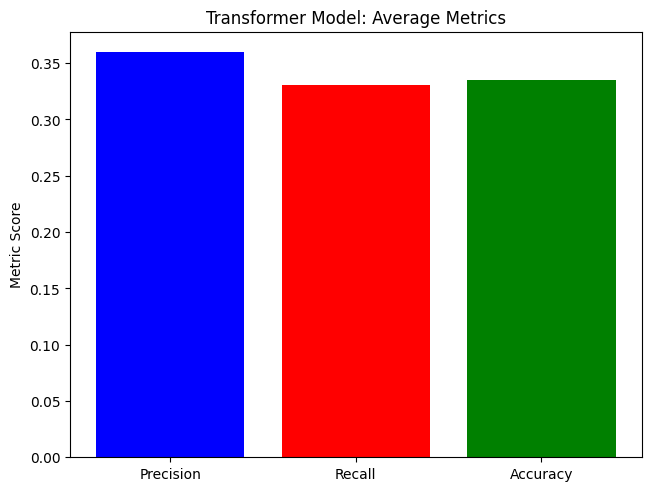

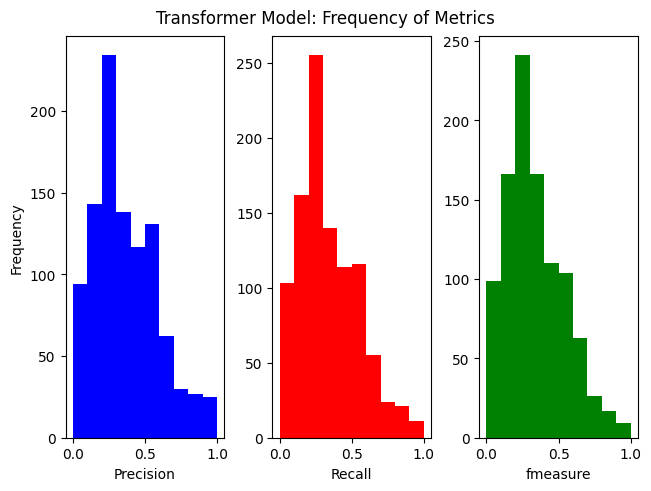

In [45]:
# Plot transformer rogue scores
plot_metrics(avg_metrics_tf, metrics_tf, "Transformer Model")

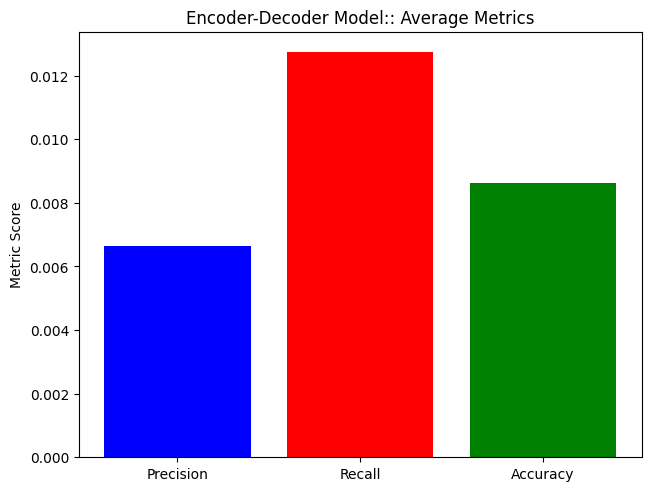

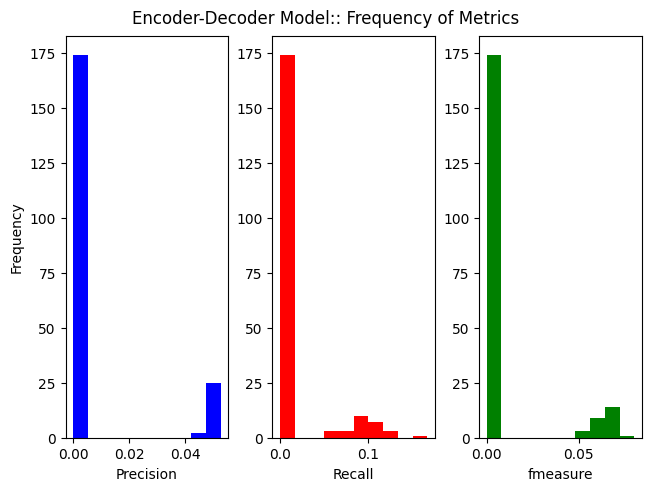

In [46]:
# Plot encoder-decoder rogue scores
plot_metrics(avg_metrics_ed, metrics_ed, "Encoder-Decoder Model:")